Complex Total Variation Denoising with NLPADMM Solver
=====================================================

This example demonstrates solution of a problem of the form

$$\argmin_{\mb{x}} \; f(\mb{x}) + g(\mb{z}) \; \text{such that}\;
H(\mb{x}, \mb{z}) = 0 \;,$$

where $H$ is a nonlinear function, via a variant of the proximal ADMM
algorithm for problems with a non-linear operator constraint
<cite data-cite="benning-2016-preconditioned"/>. The example problem represents
total variation (TV) denoising applied to a complex image with
piece-wise smooth magnitude and non-smooth phase. (This example is rather
contrived, and was not constructed to represent a specific real imaging
problem, but it does have some properties in common with synthetic
aperture radar single look complex data in which the magnitude has much
more discernible structure than the phase.) The appropriate TV denoising
formulation for this problem is

$$\argmin_{\mb{x}} \; (1/2) \| \mb{y} - \mb{x} \|_2^2 + \lambda
\| C(\mb{x}) \|_{2,1} \;,$$

where $\mb{y}$ is the measurement, $\|\cdot\|_{2,1}$ is the
$\ell_{2,1}$ mixed norm, and $C$ is a non-linear operator consisting of
a linear difference operator applied to the magnitude of a complex array.
This problem is represented in the form above by taking $H(\mb{x},
\mb{z}) = C(\mb{x}) - \mb{z}$. The standard TV solution, which is
also computed for comparison purposes, gives very poor results since
the difference is applied independently to real and imaginary
components of the complex image.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install xdesign

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import function, functional, linop, loss, metric, operator, plot
from scico.examples import phase_diff
from scico.optimize import NonLinearPADMM, ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_mag = snp.pad(discrete_phantom(phantom, N - 16), 8) + 1.0
x_mag /= x_mag.max()
# Create reference image with structured magnitude and random phase
x_gt = x_mag * snp.exp(-1j * scico.random.randn(x_mag.shape, seed=0)[0])

Add noise to create a noisy test image.

In [3]:
σ = 0.25  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=1, dtype=snp.complex64)
y = x_gt + σ * noise

Denoise with standard total variation.

In [4]:
λ_tv = 6e-2
f = loss.SquaredL2Loss(y=y)
g = λ_tv * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=y.shape, input_dtype=snp.complex64, append=0)

solver_tv = ProximalADMM(
    f=f,
    g=g,
    A=C,
    rho=1.0,
    mu=8.0,
    nu=1.0,
    maxiter=200,
    itstat_options={"display": True, "period": 20},
)
print(f"Solving on {device_info()}\n")
x_tv = solver_tv.solve()
print()
hist_tv = solver_tv.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.46e+00  1.494e+04  1.493e+01  2.259e+01
  20  3.40e+00  3.939e+03  1.376e-03  2.686e+00


  40  3.51e+00  3.834e+03  8.634e-05  2.546e-01
  60  3.62e+00  3.834e+03  1.695e-05  2.414e-02


  80  3.71e+00  3.833e+03  1.566e-05  2.289e-03
 100  3.79e+00  3.833e+03  1.566e-05  2.191e-04
 120  3.87e+00  3.833e+03  1.392e-05  3.282e-05


 140  3.95e+00  3.833e+03  7.485e-06  1.357e-05
 160  4.02e+00  3.833e+03  7.145e-06  1.293e-05
 180  4.10e+00  3.833e+03  7.130e-06  1.286e-05


 199  4.17e+00  3.833e+03  7.138e-06  1.292e-05



Denoise with total variation applied to the magnitude of a complex image.

In [5]:
λ_nltv = 2e-1
g = λ_nltv * functional.L21Norm()
# Redefine C for real input (now applied to magnitude of a complex array)
C = linop.FiniteDifference(input_shape=y.shape, input_dtype=snp.float32, append=0)
# Operator computing differences of absolute values
D = C @ operator.Abs(input_shape=x_gt.shape, input_dtype=snp.complex64)
# Constraint function imposing z = D(x) constraint
H = function.Function(
    (C.shape[1], C.shape[0]),
    output_shape=C.shape[0],
    eval_fn=lambda x, z: D(x) - z,
    input_dtypes=(snp.complex64, snp.float32),
    output_dtype=snp.float32,
)

solver_nltv = NonLinearPADMM(
    f=f,
    g=g,
    H=H,
    rho=5.0,
    mu=6.0,
    nu=1.0,
    maxiter=200,
    itstat_options={"display": True, "period": 20},
)
x_nltv = solver_nltv.solve()
hist_nltv = solver_nltv.itstat_object.history(transpose=True)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.32e+00  1.741e+04  2.942e+00  1.563e-02


  20  1.75e+00  5.636e+03  2.205e-01  3.530e-01
  40  1.91e+00  2.448e+03  8.182e-02  1.794e-01


  60  2.05e+00  1.589e+03  4.048e-02  9.234e-02


  80  2.19e+00  1.358e+03  2.249e-02  4.799e-02
 100  2.33e+00  1.295e+03  1.390e-02  2.491e-02


 120  2.53e+00  1.279e+03  9.339e-03  1.298e-02


 140  2.72e+00  1.274e+03  6.686e-03  6.759e-03


 160  2.85e+00  1.273e+03  5.190e-03  3.534e-03


 180  2.99e+00  1.273e+03  4.173e-03  1.867e-03
 199  3.15e+00  1.273e+03  3.492e-03  1.043e-03


Plot results.

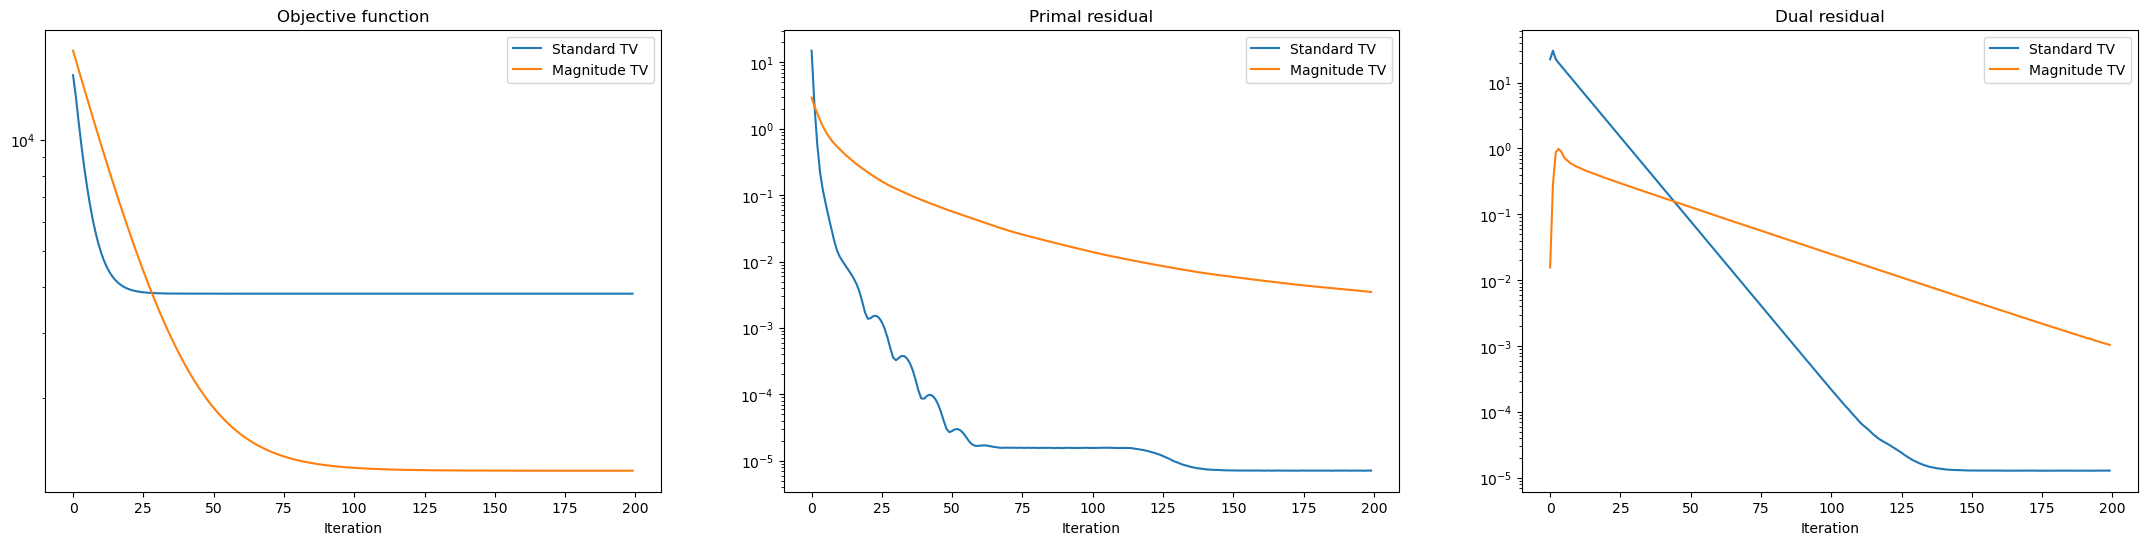

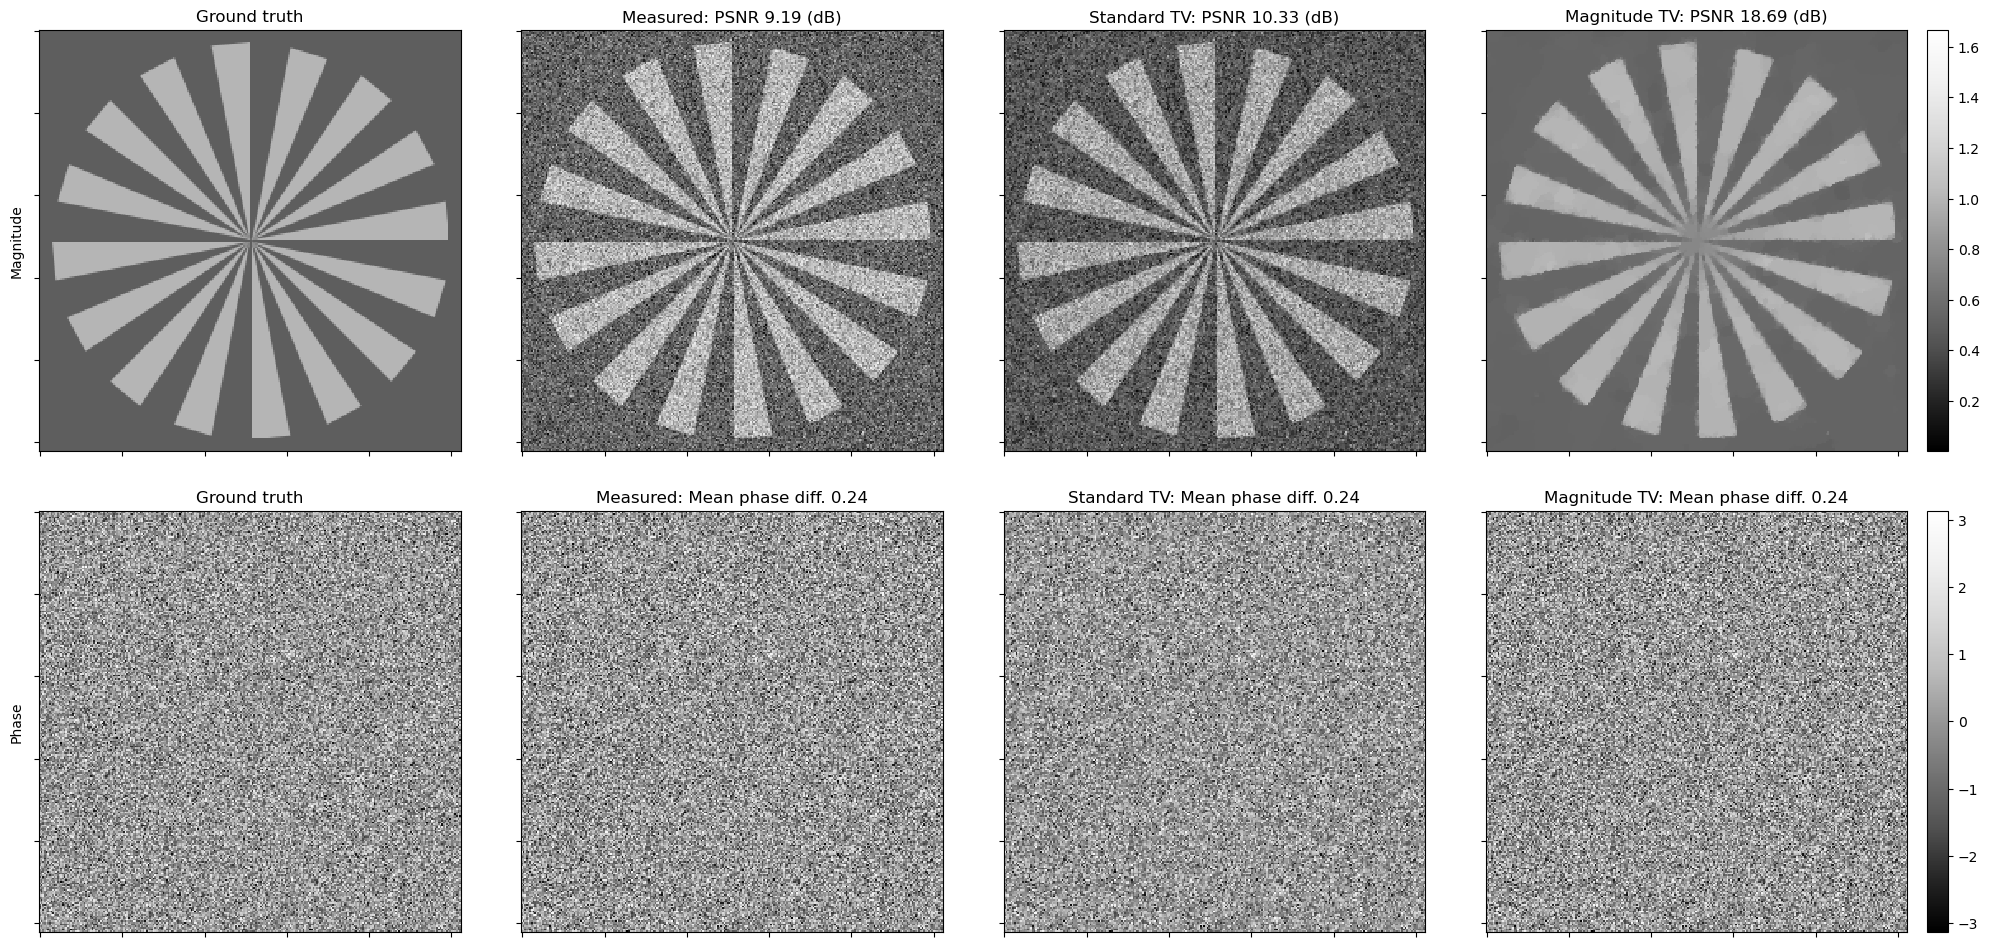

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_tv.Objective, hist_nltv.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("Standard TV", "Magnitude TV"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_tv.Prml_Rsdl, hist_nltv.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("Standard TV", "Magnitude TV"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_tv.Dual_Rsdl, hist_nltv.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("Standard TV", "Magnitude TV"),
    fig=fig,
    ax=ax[2],
)
fig.show()


fig, ax = plot.subplots(nrows=2, ncols=4, figsize=(20, 10))
norm = plot.matplotlib.colors.Normalize(
    vmin=min(snp.abs(x_gt).min(), snp.abs(y).min(), snp.abs(x_tv).min(), snp.abs(x_nltv).min()),
    vmax=max(snp.abs(x_gt).max(), snp.abs(y).max(), snp.abs(x_tv).max(), snp.abs(x_nltv).max()),
)
plot.imview(snp.abs(x_gt), title="Ground truth", cbar=None, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(
    snp.abs(y),
    title="Measured: PSNR %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(y)),
    cbar=None,
    fig=fig,
    ax=ax[0, 1],
    norm=norm,
)
plot.imview(
    snp.abs(x_tv),
    title="Standard TV: PSNR %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(x_tv)),
    cbar=None,
    fig=fig,
    ax=ax[0, 2],
    norm=norm,
)
plot.imview(
    snp.abs(x_nltv),
    title="Magnitude TV: PSNR %.2f (dB)" % metric.psnr(snp.abs(x_gt), snp.abs(x_nltv)),
    cbar=None,
    fig=fig,
    ax=ax[0, 3],
    norm=norm,
)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[0, 3].get_images()[0], cax=cax)
norm = plot.matplotlib.colors.Normalize(
    vmin=min(snp.angle(x_gt).min(), snp.angle(x_tv).min(), snp.angle(x_nltv).min()),
    vmax=max(snp.angle(x_gt).max(), snp.angle(x_tv).max(), snp.angle(x_nltv).max()),
)
plot.imview(
    snp.angle(x_gt),
    title="Ground truth",
    cbar=None,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    snp.angle(y),
    title="Measured: Mean phase diff. %.2f" % phase_diff(snp.angle(x_gt), snp.angle(y)).mean(),
    cbar=None,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
plot.imview(
    snp.angle(x_tv),
    title="Standard TV: Mean phase diff. %.2f"
    % phase_diff(snp.angle(x_gt), snp.angle(x_tv)).mean(),
    cbar=None,
    fig=fig,
    ax=ax[1, 2],
    norm=norm,
)
plot.imview(
    snp.angle(x_nltv),
    title="Magnitude TV: Mean phase diff. %.2f"
    % phase_diff(snp.angle(x_gt), snp.angle(x_nltv)).mean(),
    cbar=None,
    fig=fig,
    ax=ax[1, 3],
    norm=norm,
)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[1, 3].get_images()[0], cax=cax)
ax[0, 0].set_ylabel("Magnitude")
ax[1, 0].set_ylabel("Phase")
fig.tight_layout()
fig.show()